# PART 1: Ridge Regression

In [374]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import warnings

Below are the helper functions I am using for *visualisation* and *dataset generations*

In [375]:
#This function produces a scatterplot of just 1 set of values.
def plot(x, y, title=None):
    plt.figure(figsize=(4, 3))
    plt.scatter(x, y, color='red', s=3) 
    plt.xlabel("X values")
    plt.ylabel("Y values")
    if title:
        plt.title(title)
    else:
        plt.title("Scatterplot Comparison")
    plt.grid(True)
    plt.show()

#This function produces a comparative scatterplot of 2 sets of values (actual vs. predicted)
def plot_comparison(values1, values2, title=None):
    plt.figure(figsize=(4, 3))
    plt.scatter(values1[0], values1[1], color='red', label='Actual Values', s=3) 
    plt.scatter(values2[0], values2[1], color='blue', label='Predicted Values',s =3) 
    plt.xlabel("X values")
    plt.ylabel("Y values")
    if title:
        plt.title(title)
    else:
        plt.title("Scatterplot Comparison")
    plt.grid(True)
    plt.legend()
    plt.show()

    #This function produces a comparative scatterplot of 3 sets of values (actual vs. predicted Model 1 vs. predicted Model 2)
def plot_comparison_threeways(values1, values2, values3, model1title, model2title, title=None):
    plt.figure(figsize=(8, 6))
    plt.scatter(values1[0], values1[1], color='red', label='Actual Values', s=7) 
    plt.scatter(values2[0], values2[1], color='blue', label='Predicted Values from ' + model1title , s=7) 
    plt.scatter(values3[0], values3[1], marker = 's', color='green', label='Predicted Values from ' + model2title , s=7) 
    plt.xlabel("X values")
    plt.ylabel("Y values")
    if title:
        plt.title(title)
    else:
        plt.title("Scatterplot Comparison")
    plt.grid(True)
    plt.legend()
    plt.show()

# Generation of random toy datasets based on degree & n_samples
# Based on provided function
def generate_polynomial_dataset(degree, n_samples):
    X = np.random.uniform(-5, 5, n_samples).reshape(-1, 1)
    y = []
    for xi in X:
        sum = 0
        for ki in range(degree + 1):
            ak = np.random.uniform(0, 1)
            term = ak * (xi ** ki)
            sum += term
        e = np.random.normal(0, 1)
        yi = sum + e
        y.append(yi)
    return X, y

The below code block shows first the generation of toy datasets. The code outputs 3 plots displaying values of the generated data demonstrating the utility of the plot generation.
Next, it shows the pre-processing of data. I chose to introduce three steps of pre-processing: <br>
<br>1: Addition of polynomial features for quadratic and cubic datasets. This allows linear relationships to be formed from x^2 and x^3 respectively to y
<br>2: Scale normalisation of quadratic and cubic features, to ensure feature distance is normalised with respect to distance from the mean
<br>3: Partitioning of data into 80% training data and 20% testing data, to ensure some unseen data is set aside for validaiton of the model

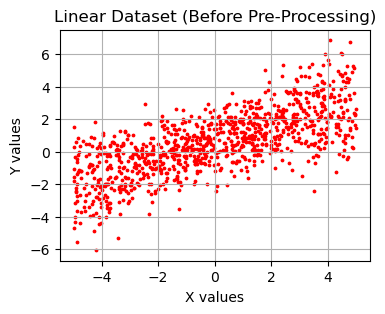

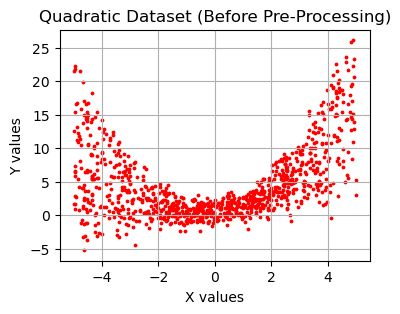

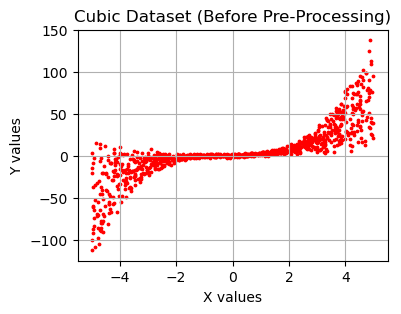

In [376]:
X_linear, y_linear = generate_polynomial_dataset(1, 1000)
X_quad, y_quad = generate_polynomial_dataset(2, 1000)
X_cubic, y_cubic = generate_polynomial_dataset(3, 1000)

plot(X_linear, y_linear, "Linear Dataset (Before Pre-Processing)")
plot(X_quad, y_quad, "Quadratic Dataset (Before Pre-Processing)")
plot(X_cubic, y_cubic, "Cubic Dataset (Before Pre-Processing)")

#Addition of polynomial features
X_quad = np.hstack((X_quad, X_quad**2))
X_cubic = np.hstack((X_cubic, X_cubic**2, X_cubic**3))

#Scale normalisation
X_quad = StandardScaler().fit_transform(X_quad)
X_cubic = StandardScaler().fit_transform(X_cubic)

#Splitting 80/20 into training and testing sets
X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(X_linear, y_linear, test_size=0.2)
X_quad_train, X_quad_test, y_quad_train, y_quad_test = train_test_split(X_quad, y_quad, test_size=0.2)
X_cubic_train, X_cubic_test, y_cubic_train, y_cubic_test = train_test_split(X_cubic, y_cubic, test_size=0.2)

## Closed Form Ridge Regression

This form of regression is the first form of regression implemented in the project. This implementation uses the closed-form solution  with harnessing the vectorised NumPy algorithm.

In [377]:
ALPHA_CHOICES = [0, 0.1, 100] #The 3 designated values that will be tested for 'alpha'


# Custom implemented Closed Form Ridge Regression
class RidgeRegression_ClosedForm():
    def __init__(self, alpha = 0.5):
        self.alpha = alpha
        self.weights = None

    def train(self, X, y):
        X = np.insert(X, X.shape[1], 1, axis=1)
        biased_i = np.identity(len(X[0]))
        biased_i[0,0] = 0
        XT = np.transpose(X)
        self.weights = np.linalg.inv((XT @ X) + self.alpha * biased_i) @ XT @ y

    def predict(self, X):
        X = np.insert(X, X.shape[1], 1, axis=1)
        return X @ self.weights

The code below completes a Closed Form Ridge Regression for each of the linear, quadratic and cubic datasets. For each, trial the different alpha parameter values of 0, 0.1 and 100 (as specified), and plot their performance

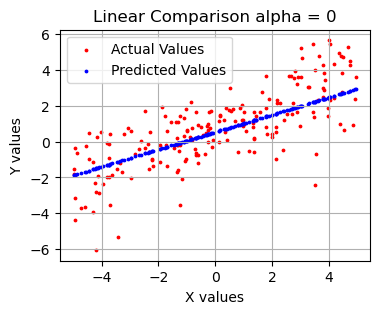

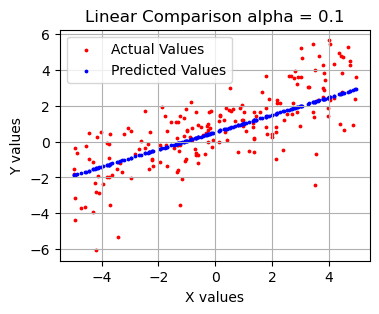

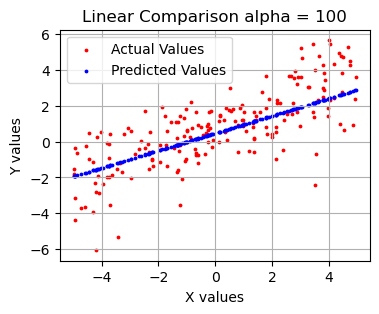

In [378]:
predicted_y_list_cf = [] # This list is being created for later comparison with the other regression model

for alpha in ALPHA_CHOICES:
    linear_reg_cf = RidgeRegression_ClosedForm(alpha = alpha)
    linear_reg_cf.train(X_linear_train, y_linear_train)
    y_linear_predicted = linear_reg_cf.predict(X_linear_test)
    predicted_y_list_cf.append(y_linear_predicted)
    plot_comparison([X_linear_test, y_linear_test], [X_linear_test, y_linear_predicted], f'Linear Comparison alpha = {alpha}')

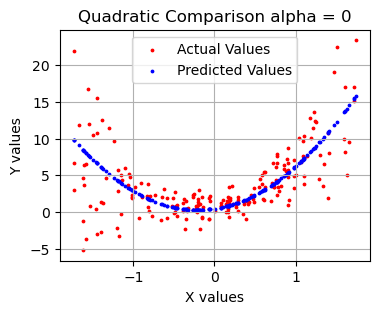

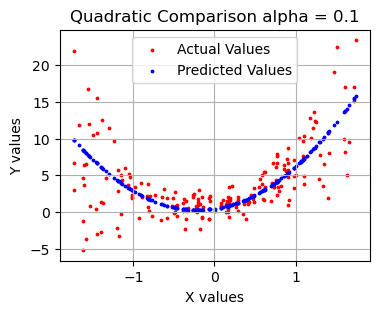

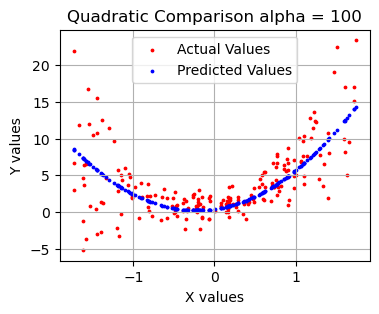

In [379]:
for alpha in ALPHA_CHOICES:
    quad_reg_cf = RidgeRegression_ClosedForm(alpha = alpha)
    quad_reg_cf.train(X_quad_train, y_quad_train)
    y_quad_predicted = quad_reg_cf.predict(X_quad_test)
    predicted_y_list_cf.append(y_quad_predicted)
    plot_comparison([X_quad_test[:,0], y_quad_test], [X_quad_test[:,0], y_quad_predicted], f'Quadratic Comparison alpha = {alpha}')

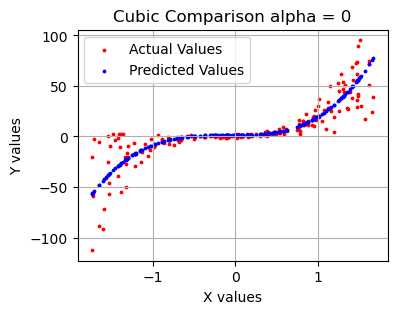

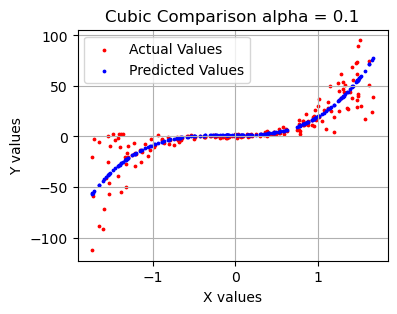

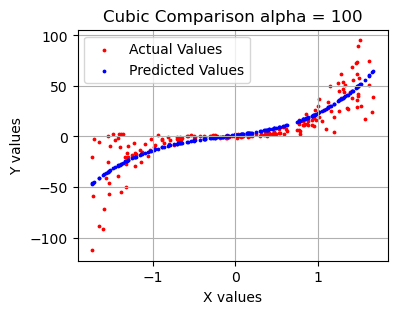

In [380]:
for alpha in ALPHA_CHOICES:
    cubic_reg_cf = RidgeRegression_ClosedForm(alpha = alpha)
    cubic_reg_cf.train(X_cubic_train, y_cubic_train)
    y_cubic_predicted = cubic_reg_cf.predict(X_cubic_test)
    predicted_y_list_cf.append(y_cubic_predicted)
    plot_comparison([X_cubic_test[:,0], y_cubic_test], [X_cubic_test[:,0], y_cubic_predicted], f'Cubic Comparison alpha = {alpha}')

## SGD Regression

The following code runs a SGD Regression model on the same linear, quadratic and cubic datasets. It similarly trials different alpha parameter values and visualises the results.

In [381]:
MAX_ITERATIONS = 1000 # Chosen to optimise computation time and solution accuracy
predicted_y_list_SGD = [] # Used for eventual comparison with Closed Form Regressions done on same dataset
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn") # Ignore non-problematic errors

#Function for creating SGDRegressor object, training and predicting it. It returns the predicted (y) value list
def predict_SGDReg(X, Y, X_test, alpha):
    sgd_reg = SGDRegressor(penalty='l2', alpha=alpha, max_iter=MAX_ITERATIONS)
    sgd_reg.fit(X, Y)
    return sgd_reg.predict(X_test)

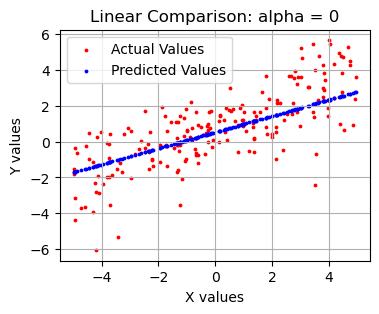

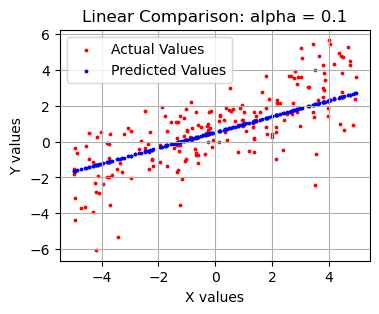

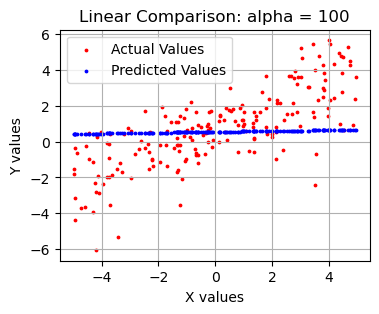

In [382]:
for i, alpha in enumerate(ALPHA_CHOICES):
    y_linear_predicted = predict_SGDReg(X_linear_train, y_linear_train, X_linear_test, alpha)
    predicted_y_list_SGD.append(y_linear_predicted)
    plot_comparison([X_linear_test, y_linear_test], [X_linear_test, y_linear_predicted], f'Linear Comparison: alpha = {alpha}')
    

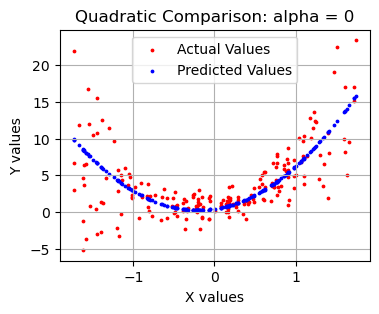

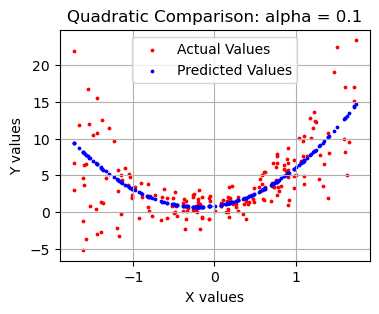

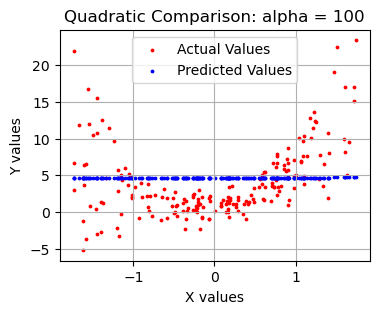

In [383]:
for i, alpha in enumerate(ALPHA_CHOICES):
    y_quad_predicted = predict_SGDReg(X_quad_train, y_quad_train, X_quad_test, alpha)
    predicted_y_list_SGD.append(y_quad_predicted)
    plot_comparison([X_quad_test[:,0], y_quad_test], [X_quad_test[:,0], y_quad_predicted], f'Quadratic Comparison: alpha = {alpha}')


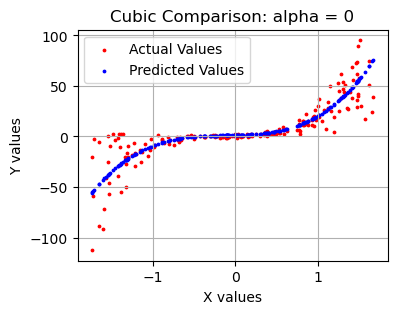

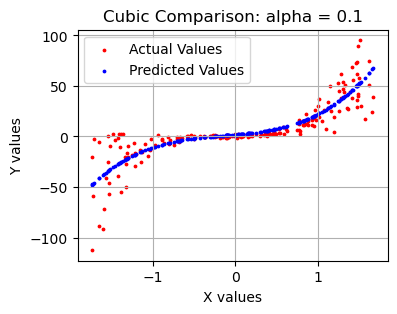

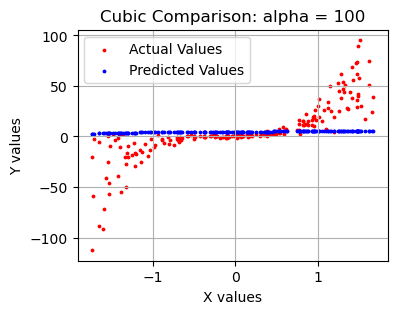

In [384]:
for i, alpha in enumerate(ALPHA_CHOICES):
    y_cubic_predicted = predict_SGDReg(X_cubic_train, y_cubic_train, X_cubic_test, alpha)
    predicted_y_list_SGD.append(y_cubic_predicted)
    plot_comparison([X_cubic_test[:,0], y_cubic_test], [X_cubic_test[:,0], y_cubic_predicted], f'Cubic Comparison: alpha = {alpha}')
    

#### Compare the models of regression on linear, quadratic and cubic datasets for each of the three alpha parameters 

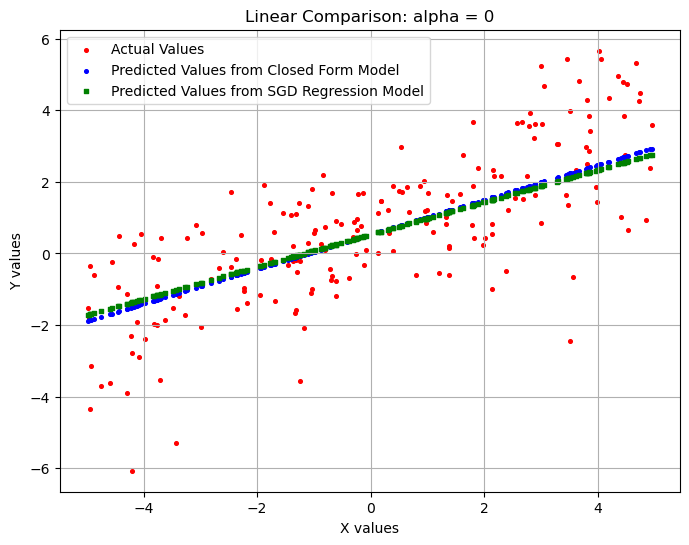

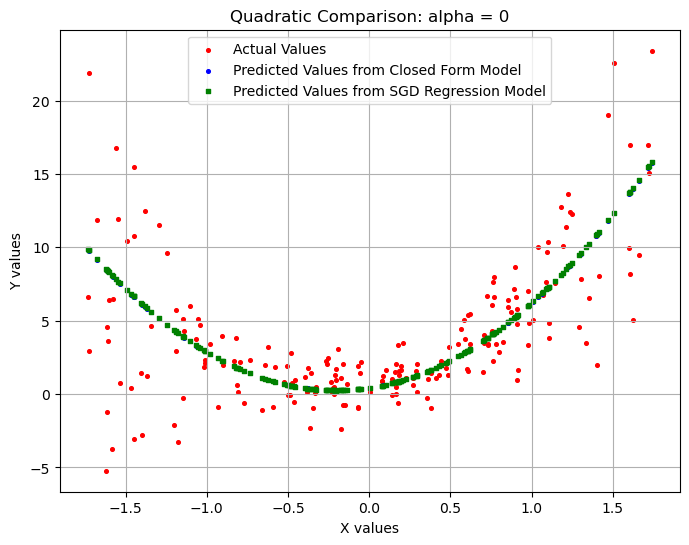

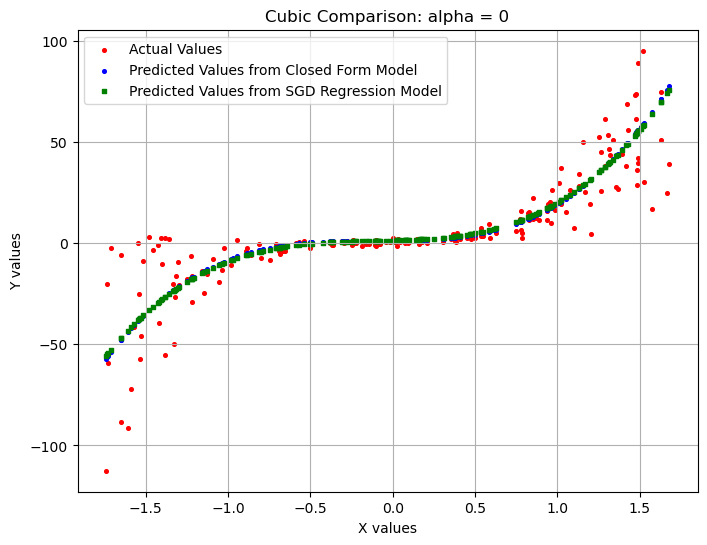

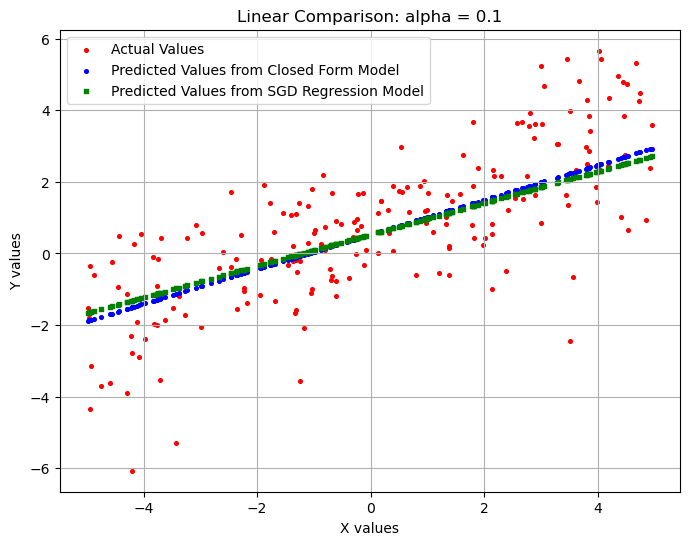

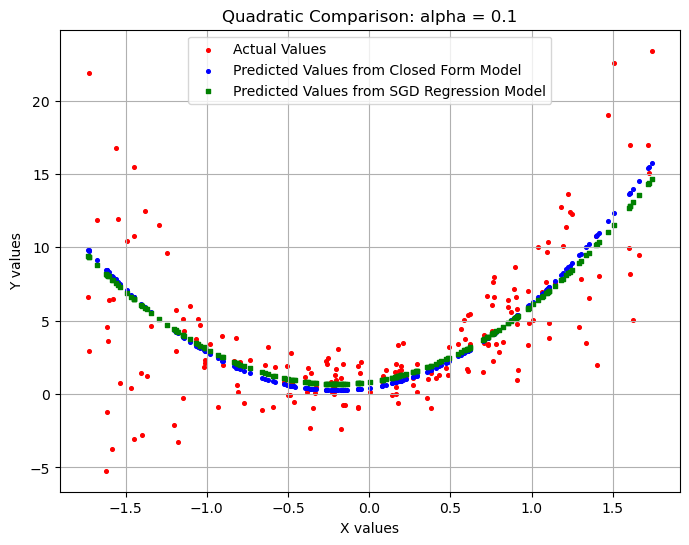

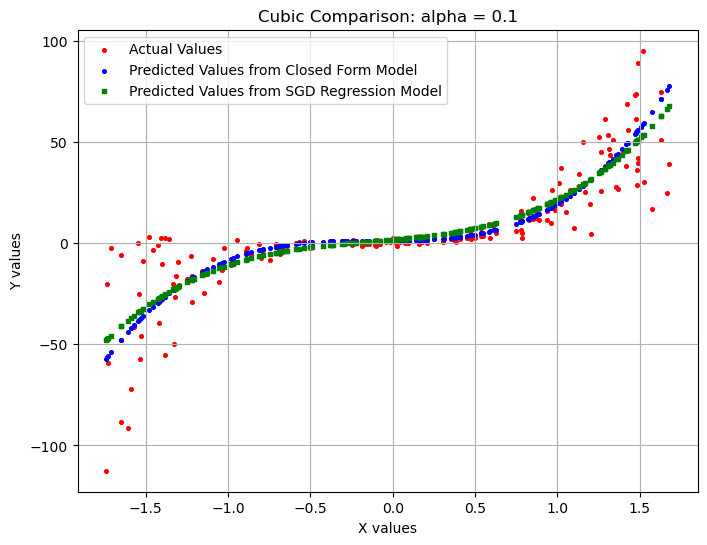

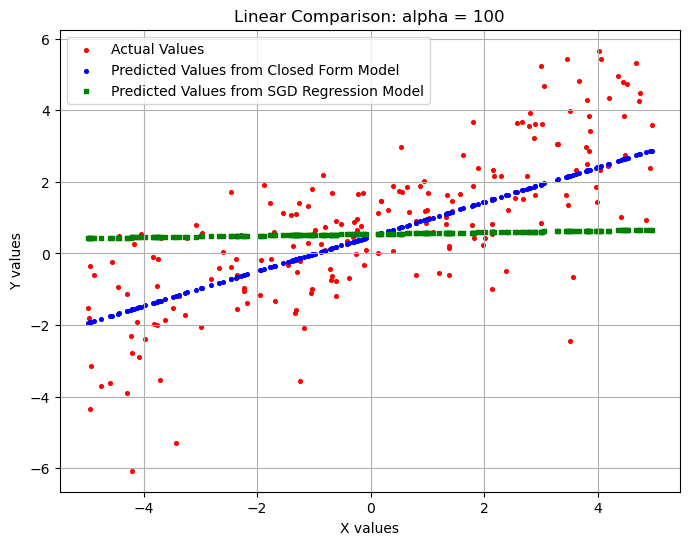

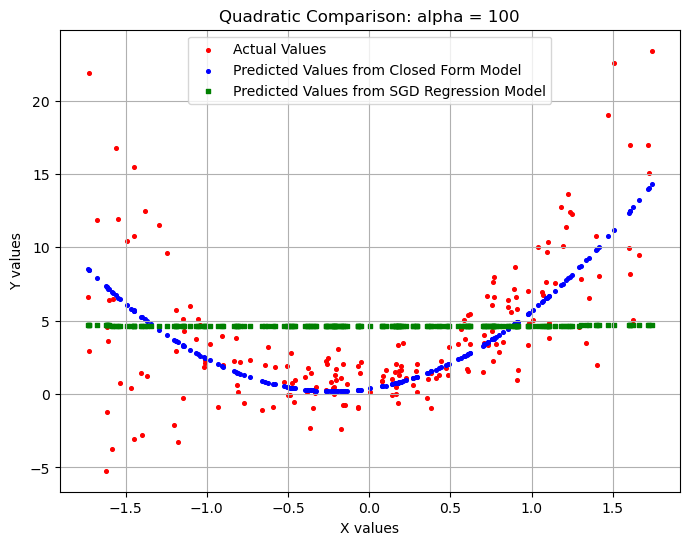

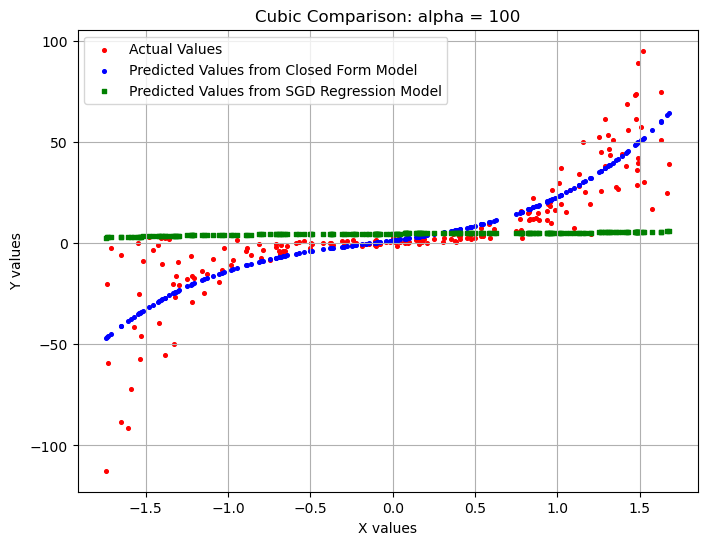

In [385]:
for i in range(3):
    plot_comparison_threeways([X_linear_test, y_linear_test], [X_linear_test, predicted_y_list_cf[i]], [X_linear_test, predicted_y_list_SGD[i]], 'Closed Form Model','SGD Regression Model',f'Linear Comparison: alpha = {ALPHA_CHOICES[i]}')
    plot_comparison_threeways([X_quad_test[:,0], y_quad_test], [X_quad_test[:,0], predicted_y_list_cf[3+i]], [X_quad_test[:,0], predicted_y_list_SGD[3+i]], 'Closed Form Model','SGD Regression Model',f'Quadratic Comparison: alpha = {ALPHA_CHOICES[i]}')
    plot_comparison_threeways([X_cubic_test[:,0], y_cubic_test], [X_cubic_test[:,0], predicted_y_list_cf[6+i]], [X_cubic_test[:,0], predicted_y_list_SGD[6+i]], 'Closed Form Model','SGD Regression Model',f'Cubic Comparison: alpha = {ALPHA_CHOICES[i]}')

# PART 2: Support Vector Classifier

In [386]:
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix


Helper function for visualising the distribution of different features

In [387]:
def visualise_features(mean, se, worst, features):
    fig, axes = plt.subplots(10, 1, figsize=(6, 30))

    for i in range(10):
        sns.histplot(mean.iloc[:, i], ax=axes[i], color='blue', label='Mean')
        sns.histplot(se.iloc[:, i], ax=axes[i], color='red', label='SE')
        sns.histplot(worst.iloc[:, i], ax=axes[i], color='green', label='Worst')
        
        axes[i].set_title(f'Distribution of {features[i]} ')
        axes[i].set_xlabel(f'{features[i]}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

### Preprocessing of data:

First read the data into a dataframe, and apply the following headings to the column indexes: 
<br>0 = ID: Can be discarded
<br>1 = y array (classifications)
<br>2-11 = Mean values of radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, fractal dimensions
<br>12-21 = Standard error of values of same 10 fields
<br>22-31 = Worst value of same 10 fields

Then create separate data frames for the mean, standard error and worst fields, and visualise each of them

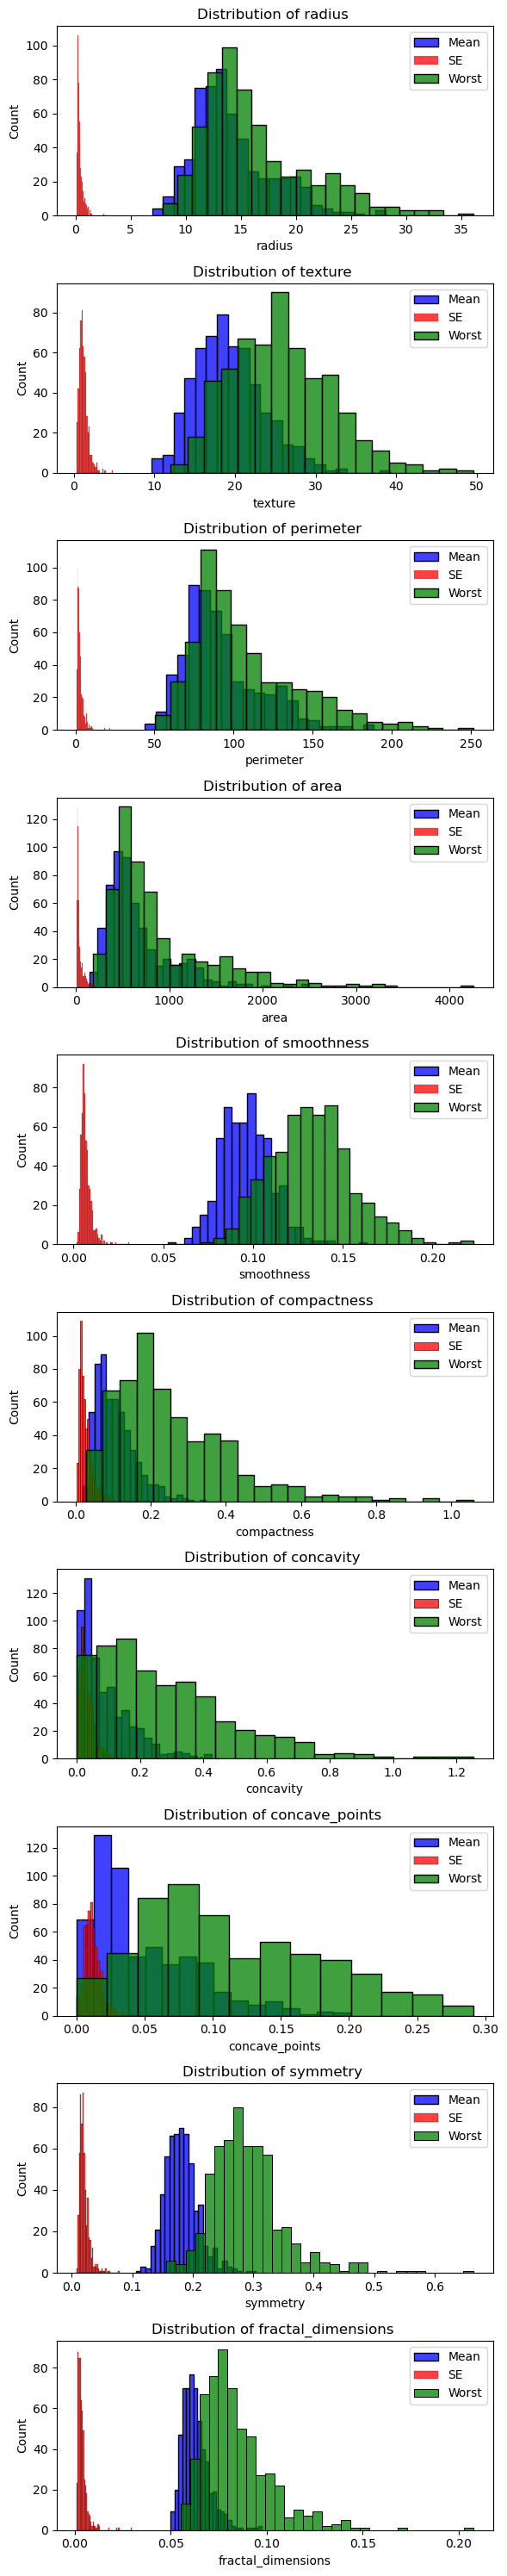

In [388]:
FEATURES = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimensions"]

data = pd.read_csv('data/wdbc.data', header=None)

headings = ['id', 'diagnosis']
for feature_type in ['mean','se','worst']:
    for feature in FEATURES:
        headings.append(feature_type + '_' + feature)

data.columns = headings

data.drop(columns=['id'], inplace=True)

mean_df = data.iloc[:, 1:11]
se_df = data.iloc[:, 11:21]
worst_df = data.iloc[:, 21:31]

visualise_features(mean_df, se_df, worst_df, FEATURES)

Next the data is split into corresponding feature & class pairs, stored in X and y arrays. The data is split 80/20 into training and test data. I initially considered considered ommitting the worst data points, as I thought it may be too anomalous, and incorrectly influence predictions. However, upon comparison on mean + se and mean + se + worst for X, analysis showed that inclusion of worst data points significantly improves the accuracy, so I included it as well as the se and mean data. 

In [389]:
mean = mean_df.values
se = se_df.values
worst = worst_df.values

X = mean + se + worst

X = StandardScaler().fit_transform(X)
y = data.iloc[:, 0].values

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2) # DO I NEED TO STRATIFY THIS?

The parameter grid is then constructed

In [390]:
parameter_grid = {
    'C': [0.5, 1.0, 3.0, 10.0], # C parameter (regularisation)
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernel types
    'class_weight': ['balanced', None] # whether classes should be weighted inversely proporitional to frequency or treated equally
}

svc = SVC(probability=True)
strat_cv = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(svc, parameter_grid, cv=strat_cv, scoring='accuracy')
grid_search.fit(train_X, train_y)
optimal_model = grid_search.best_estimator_

print(grid_search.best_params_)

score = optimal_model.score(test_X,test_y)
print(f'ACCURACY: {score}')



{'C': 1.0, 'class_weight': None, 'kernel': 'rbf'}
ACCURACY: 0.9298245614035088


(a) Do you need to stratify your cross-validation? - yes
(b) What scoring metric is most appropriate for this task? 
(c) What hyperparameters did you choose? How many models did you fit in total? 
(d) Present your results for the optimal hyperparameter combination.


ACCURACY: 0.9298245614035088


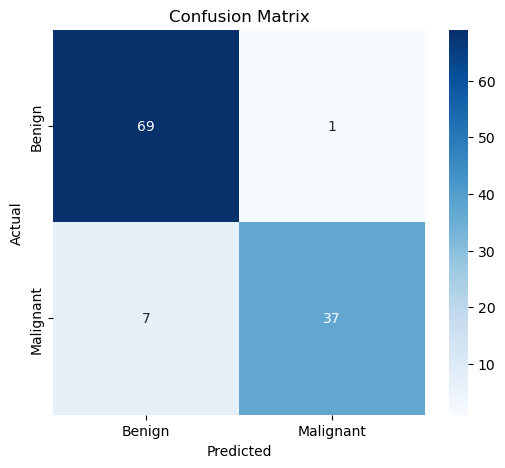

In [391]:
score = optimal_model.score(test_X,test_y)
print(f'ACCURACY: {score}')

predicted_y = optimal_model.predict(test_X)

confusion = confusion_matrix(test_y, predicted_y)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# I DONT KNOW IF I SHOULD DO THIS OR NOT?

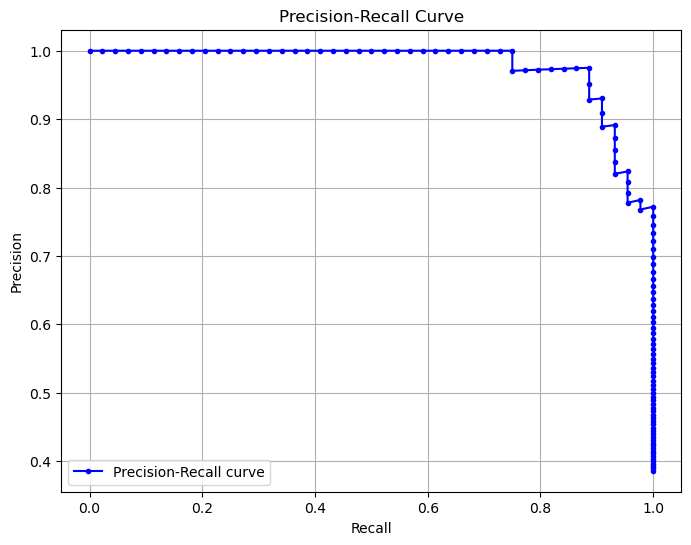

In [392]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for the positive class
y_prob = optimal_model.predict_proba(test_X)[:, 1]  # Probabilities for the positive class

# Compute precision and recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(test_y, y_prob, pos_label='M')

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='blue', label='Precision-Recall curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()